Web Scraper

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL of the main Pokemon list page
base_url = "https://pokemondb.net"
list_url = f"{base_url}/pokedex/national"

response = requests.get(list_url)
soup = BeautifulSoup(response.text, 'html.parser')

pokemon_links = soup.select('.infocard a.ent-name')
pokemon_data = []

# Extract data
for link in pokemon_links:
    name = link.text
    url = f"{base_url}{link['href']}"

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    entries_table = soup.find('h2', string='Pokédex entries')
    if entries_table:
        entries_table = entries_table.find_next('table')
        entries = [entry.text.strip() for entry in entries_table.select('td.cell-med-text')]
    else:
        entries = []
        print(f"No Pokédex entries found for {name}")

    # Find the stats table
    stats_table = soup.find('h2', string='Base stats').find_next('table')
    stats = {}
    for row in stats_table.select('tbody > tr'):
        stat_name = row.find('th').text.strip()
        stat_value = row.find('td', class_='cell-num').text.strip()
        stats[stat_name] = stat_value

    for entry in entries:
        pokemon_data.append({
            'entry': entry,
            'hp': stats['HP'],
            'attack': stats['Attack'],
            'defense': stats['Defense'],
            'sp_atk': stats['Sp. Atk'],
            'sp_def': stats['Sp. Def'],
            'speed': stats['Speed'],
        })

# Save to CSV
df = pd.DataFrame(pokemon_data)
df.to_csv('pokemon_entries_stats.csv', index=False)

No Pokédex entries found for Walking Wake
No Pokédex entries found for Iron Leaves
No Pokédex entries found for Dipplin
No Pokédex entries found for Poltchageist
No Pokédex entries found for Sinistcha
No Pokédex entries found for Okidogi
No Pokédex entries found for Munkidori
No Pokédex entries found for Fezandipiti
No Pokédex entries found for Ogerpon
No Pokédex entries found for Archaludon
No Pokédex entries found for Hydrapple
No Pokédex entries found for Gouging Fire
No Pokédex entries found for Raging Bolt
No Pokédex entries found for Iron Boulder
No Pokédex entries found for Iron Crown
No Pokédex entries found for Terapagos
No Pokédex entries found for Pecharunt


Randomize the order of the csv file to reduce bias


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('pokemon_entries_stats.csv')

randomized_df = df.sample(frac=1, random_state=42)

randomized_df.to_csv('pokemon_entries_stats_randomized.csv', index=False)

Peek at the data

In [3]:
# Load the dataset
data_path = 'pokemon_entries_stats_randomized.csv'
data = pd.read_csv(data_path)

print(data.head())

                                               entry   hp  attack  defense  \
0  Its healthy appetite leads to visible growth s...   70      55       75   
1  The rich, fluffy fur that covers its body feel...  140      70       45   
2  It has eyes that can see through anything. It ...   80     120       79   
3  The fragrance of the garland on its head has a...   70      60       75   
4  An examination of its cells revealed the prese...   55      65       95   

   sp_atk  sp_def  speed  
0      45      65     60  
1      85      50     45  
2      95      79     70  
3     110      75     90  
4      95      45     85  


Preprocessing

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

data['processed_entries'] = data['entry'].apply(preprocess_text)
stats = data[['hp', 'attack', 'defense', 'sp_atk', 'sp_def', 'speed']]

stats_normalized = (stats - stats.mean()) / stats.std()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Split data

In [5]:
from sklearn.model_selection import train_test_split

# Splitting the dataset
train, temp = train_test_split(data, test_size=0.2, random_state=42)
valid, test = train_test_split(temp, test_size=0.5, random_state=42)

# Tokenize and pad sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train['processed_entries'])

train_sequences = tokenizer.texts_to_sequences(train['processed_entries'])
valid_sequences = tokenizer.texts_to_sequences(valid['processed_entries'])
test_sequences = tokenizer.texts_to_sequences(test['processed_entries'])

train_padded = pad_sequences(train_sequences, padding='post', maxlen=100)
valid_padded = pad_sequences(valid_sequences, padding='post', maxlen=100)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=100)

# Extract normalized stats for training and validation
train_stats = stats_normalized.loc[train.index].values
valid_stats = stats_normalized.loc[valid.index].values


Build Model

In [30]:
import tensorflow as tf

# RNN model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=100),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6)  # One output for each stat
])

# Compile w/ mse
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

# Train the model
history = model.fit(train_padded, train_stats, epochs=10, validation_data=(valid_padded, valid_stats))


Epoch 1/10
296/296 [==============================] - 13s 32ms/step - loss: 0.8684 - mean_absolute_error: 0.7193 - val_loss: 0.7203 - val_mean_absolute_error: 0.6452
Epoch 2/10
296/296 [==============================] - 4s 14ms/step - loss: 0.6198 - mean_absolute_error: 0.5908 - val_loss: 0.6226 - val_mean_absolute_error: 0.5996
Epoch 3/10
296/296 [==============================] - 4s 12ms/step - loss: 0.4460 - mean_absolute_error: 0.5027 - val_loss: 0.5121 - val_mean_absolute_error: 0.5355
Epoch 4/10
296/296 [==============================] - 4s 12ms/step - loss: 0.3132 - mean_absolute_error: 0.4206 - val_loss: 0.4798 - val_mean_absolute_error: 0.5100
Epoch 5/10
296/296 [==============================] - 4s 12ms/step - loss: 0.2395 - mean_absolute_error: 0.3658 - val_loss: 0.4686 - val_mean_absolute_error: 0.4890
Epoch 6/10
296/296 [==============================] - 4s 12ms/step - loss: 0.1900 - mean_absolute_error: 0.3245 - val_loss: 0.4482 - val_mean_absolute_error: 0.4697
Epoch 7/1

Loss curves

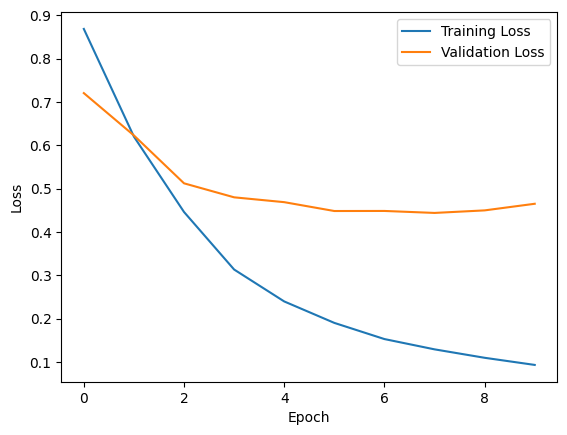

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluate Model

In [32]:
test_loss, test_mae = model.evaluate(test_padded, stats_normalized.loc[test.index].values)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

37/37 [==============================] - 0s 5ms/step - loss: 0.4622 - mean_absolute_error: 0.4474
Test Loss: 0.4622, Test MAE: 0.4474


Peek at Predictions

In [33]:
num_samples = 5
sample_indices = np.random.choice(len(test), num_samples, replace=False)

for idx in sample_indices:
    entry = test.iloc[idx]['entry']
    true_stats = stats.iloc[test.index[idx]]
    predicted_stats_normalized = model.predict(np.expand_dims(test_padded[idx], axis=0))
    predicted_stats_normalized = predicted_stats_normalized.reshape(-1)

    # Denormalize the predicted stats
    predicted_stats = np.round(predicted_stats_normalized * stats.std().values + stats.mean().values)

    print(f"Pokédex Entry: {entry}")
    print(f"True Stats: {true_stats.values}")
    print(f"Predicted Normalized Stats: {predicted_stats_normalized}")
    print(f"Predicted Stats: {predicted_stats}")
    print("---")

1/1 [==============================] - 1s 648ms/step
Pokédex Entry: This POKéMON’s stomach is so strong, even eating moldy or rotten food will not affect it.
True Stats: [160 110  65  65 110  30]
Predicted Normalized Stats: [ 3.674666    0.32169843 -0.16602542 -0.08142618  1.1114341  -1.13347   ]
Predicted Stats: [171.  84.  65.  65.  99.  34.]
---
1/1 [==============================] - 0s 21ms/step
Pokédex Entry: Although it always pretends to be a tree, its composition appears to be closer to a rock than a plant.
True Stats: [ 70 100 115  30  65  30]
Predicted Normalized Stats: [-0.37459874  0.63916653  1.3216221  -1.4761685  -1.0870728  -1.0031598 ]
Predicted Stats: [ 58.  93. 109.  26.  40.  38.]
---
1/1 [==============================] - 0s 21ms/step
Pokédex Entry: As its body grows, large mushrooms named tochukaso start sprouting out of its back.
True Stats: [35 70 55 45 55 25]
Predicted Normalized Stats: [-1.093967   -0.4092077  -0.45202622 -0.79398054 -0.77772355 -1.2858483 ]
P